# Predicting Housing Prices in Cook County
Preliminary work, feel free to distribute

**Portion 1**, we will perform some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions.

**Portion 2**, we will specify and fit a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance.

# The Cook County Assessor's Office

The dataset comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing [“racially discriminatory assessments and taxes."]
(https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html) The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, ["The Tax Divide"](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html), delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments [had] been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

Additionally, the discrimination described in the lawsuit is built on a much deeper history - including the practice of redlining in Chicago. Though this is by no means a comprehensive history, Merriam-Webster defines redlining as the "withholdding of home-loan funds or insurance from neighborhoods considered poor economic risks." The neighborhoods in this category, however, were typically comprised of Black communities; redlining, then, systemically prevented Black residents from moving into other neighborhoods and improving their current homes by denying them the financial assistance that white residents were afforded. Though the Fair Housing Act of 1968 outlawed redlining, its [impacts](https://www.washingtonpost.com/news/wonk/wp/2018/03/28/redlining-was-banned-50-years-ago-its-still-hurting-minorities-today/) and [practices](https://www.chicagotribune.com/business/ct-biz-modern-day-redlining-20180215-story.html) are still present today.

This context is vital to understanding how the Cook County Residential Sales Data - the dataset - was procured. This introduction aims to address how legacies of racial discrimination practices can be encoded within data, as well as consider how they might influence modeling choices.

# Tools

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

The [CCAO dataset](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) consists of over 500 thousand records describing houses sold in Cook County in recent years (new records are still coming in every week!). The data set has 61 features in total. An explanation of each variable can be found in the included `codebook.txt` file. Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting. 

The data are split into training and test sets with 204792 and 68264 observations, respectively.

Let's first extract the data from the `cook_county_data.zip`. Notice we didn't leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [2]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

Let's load the training and test data.

In [3]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# 68264 observations and 61 features in test data
assert test_data.shape == (68264, 61)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

The next order of business is getting a feel for the variables in our data. The Cook County data set contains information that typical homebuyers would want to know. A more detailed description of each variable is included in codebook.txt (in the same directory as this notebook).

Let's take a quick look at all the current columns in our training data.

In [5]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

# Portion 1: Data Visualization

# Part 1: Contextualizing the Data
Let's try to understand the background of our dataset before diving into a full-scale analysis. 

Prior to the open data initiative and even prior to the assessment modeling initiative, Cook County’s assessor office received much of their data for assessments from their relationships with [“local elected officials, community leaders, real estate professionals and other citizens knowledgeable about real estate in the area.”](https://www.cookcountyassessor.com/about-cook-county-assessors-office) Because CCAO field inspectors cannot enter homes to gather data, this information must be gathered through either curbside observations or real estate records.

You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf).

# Part 2: Exploratory Data Analysis
In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining the distribution of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable. The following helper method `plot_distribution` that you can use to visualize the distribution of the `SalePrice` using both the histogram and the box plot at the same time. Run the following 2 cells and describe what you think is wrong with the visualization.

In [6]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].artists[0].set_facecolor('white')

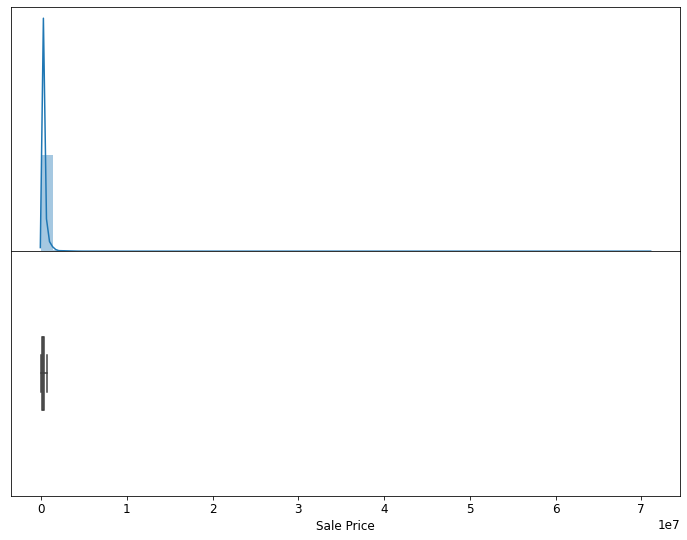

In [7]:
plot_distribution(training_data, label='Sale Price')

We have some outliers that significantly greater than rest of the data, so we can use logarithm to flatten the data. 

### Part 1
To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price` for now. In addition, it may be a good idea to apply log transformation to `Sale Price`. In the cell below, reassign `training_data` to a new dataframe that is the same as the original one **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.

In [8]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

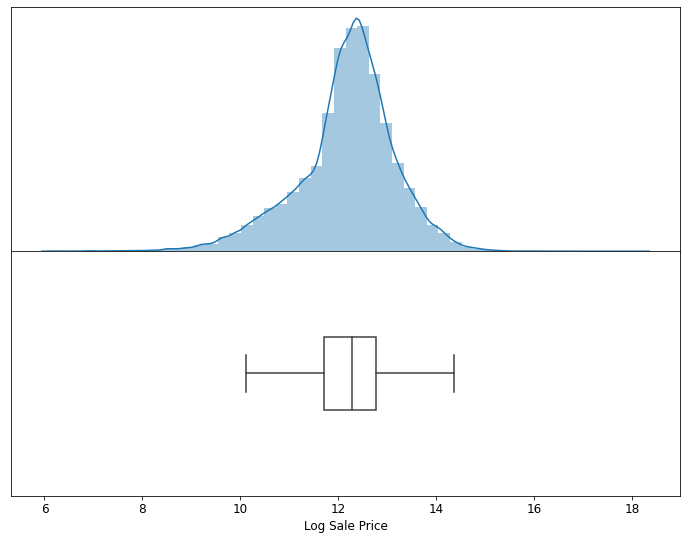

In [9]:
plot_distribution(training_data, label='Log Sale Price');

### Part 2

Next, we want to explore if any there is any correlation between `Log Sale Price` and the total area occupied by the household. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Before creating this jointplot however, let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, create a new column `Log Building Square Feet` in our training data that contains the log transformed area occupied by each household. 

In [10]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

### Part 3

As shown below, we created a joint plot with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, we fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, does there exist a correlation between `Log Sale Price` and `Log Building Square Feet`? Would `Log Building Square Feet` make a good candidate as one of the features for our model?

![Joint Plot](images/q2p3_jointplot.png)

We will work to remove these outliers from the data as we run into them. Write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Building Square Feet', upper=8000)` should return a data frame with only observations that satisfy `Building Square Feet` less than or equal to 8000.

In [11]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    data = data[data[variable] >= lower]
    data = data[data['Sale Price'] <= upper]
    return data

# Part 3: Feature Engineering

In this section we will walk you through a few feature engineering techniques. 

### Bedrooms

### Part 1
Let's start simple by extracting the total number of bedrooms as our first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original dataframe! Instead, it is part of the `Description` column.

In [12]:
training_data['Description'].values[0]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

### Part 2

Write a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bathrooms (as integers) for each house. **Treat missing values as zeros if necessary**. Remember that you can make use of vectorized code here; you shouldn't need any `for` statements. 

In [13]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    pattern = r'(\d+) of which are bedrooms'
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(pattern).astype(int)
    return with_rooms

training_data = add_total_bedrooms(training_data)

### Part 3

Create a visualization that clearly and succintly shows if there exists an association between  `Bedrooms` and `Log Sale Price`. A good visualization should satisfy the following requirements:
- It should avoid overplotting.
- It should have clearly labeled axes and succinct title.
- It should convey the strength of the correlation between the sale price and the number of rooms. 

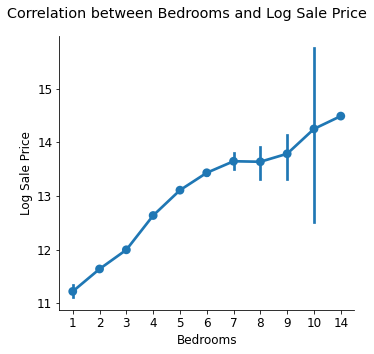

In [14]:
sns.catplot(x="Bedrooms", y="Log Sale Price", kind="point", data=training_data.sort_values(by = 'Bedrooms'))
plt.suptitle("Correlation between Bedrooms and Log Sale Price")
plt.subplots_adjust(top=0.9);

### Neighborhoods

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set. Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column Neighborhood Code (which is a numerical encoding of the actual neighborhoods by the Assessment office).

### Part 1

Before creating any visualization, let's quickly inspect how many different neighborhoods we are dealing with.

Assign the variable `num_neighborhoods` with the total number of neighborhoods in `training_data`.

In [15]:
num_neighborhoods = training_data['Neighborhood Code'].unique().size

### Part  2

If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we would get the following visualization.
![overplot](images/q5p2_catplot.png)

In [16]:
def plot_categorical(neighborhoods, data, with_filter=True):
    if not with_filter:
        neighborhoods = data
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

You might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

Assign the variable `in_top_20_neighborhoods` to a copy of `training_data` that contains only neighborhoods with the top 20 number of buildings.

In [17]:
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(training_data.groupby('Neighborhood Code').size().nlargest(20).index)]

### Part 3
### Top 20 Neighborhoods
Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

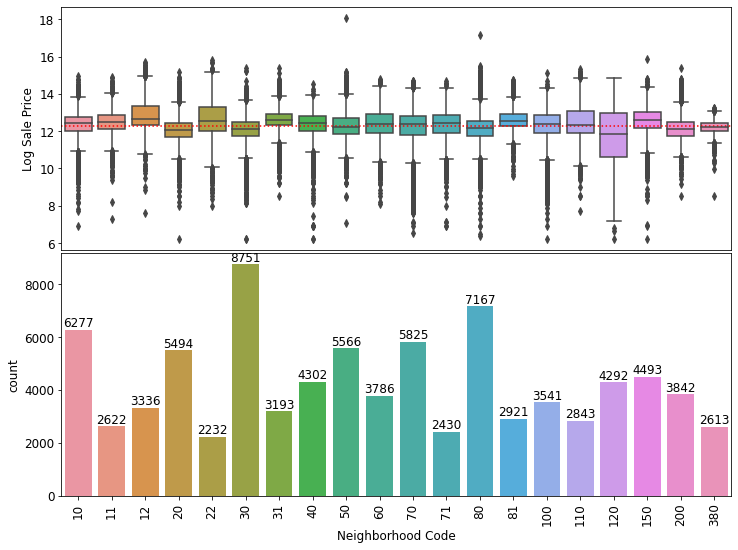

In [18]:
plot_categorical(neighborhoods=in_top_20_neighborhoods, data=training_data)

### Part 4
### Expensive Neighborhoods
One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `Log Sale Price` and identify them as "expensive neighborhoods"; the other neighborhoods are not marked.

Write a function that returns list of the neighborhood codes of the top `n` most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_expensive_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `Log Sale Price`.

In [19]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code').agg(metric).nlargest(n, ['Log Sale Price']).index
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

### Part 5 
### In expensive neighborhood
We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write a function `add_expensive_neighborhood` that adds a column `in_expensive_neighborhood` which takes on the value 1 if the house is part of `expensive_neighborhoods` and the value 0 otherwise. This type of variable is known as an indicator variable.

In [20]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebookS
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = training_data['Neighborhood Code'].isin(neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

### Roof material
In the following question, we will take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

### Part 1

If we look at the codebook carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Central Heating (Nominal): 

       1	Shingle/Asphalt
       2	Tar&Gravel
       3	Slate
       4	Shake
       5    Tile
       6    Other
```

Write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material. Your function should return a new DataFrame, not modify the existing DataFrame.

In [21]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.copy()
    factor_dict = {
        'Roof Material': { 1: 'Shingle/Asphalt', 2: 'Tar&Gravel', 3: 'Slate', 4: 'Shake', 5: 'Tile', 6: 'Other'}
    }
    data.replace(factor_dict, inplace=True)
    return data
    
training_data = substitute_roof_material(training_data)

### Part 2

#### An Important Note on One Hot Encoding 

Unfortunately, simply fixing these missing values isn't sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/user_guide/categorical.html).

Complete the following function `ohe_roof_material` that returns a dataframe with the new column one-hot-encoded on the roof material of the household. These new columns should have the form `x0_MATERIAL`.

In [22]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    ohe_df = data.copy()
    ohe = OneHotEncoder(sparse=False)
    ohe_col = ohe.fit_transform(data[['Roof Material']])
    ohe.categories_[0] = 'x0_' + ohe.categories_[0]
    ohe_df[ohe.categories_[0]] = ohe_col
    return ohe_df

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^x0').head(10)

,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


# Portion 2: Prediction

## Part 1: Train-test split
Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

In the cell below, complete the function `train_test_split` that splits `data` into two smaller DataFrames named `train` and `test`. Let `train` contain 80% of the data, and let `test` contain the remaining 20% of the data. 

In [23]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    SPLIT = 0.8
    n_train = int(data_len * SPLIT)
    train_indices = shuffled_indices[:n_train]
    test_indices = shuffled_indices[n_train:]
    return data.iloc[train_indices], data.iloc[test_indices]
train, test = train_test_split(training_data)

## Part 2: Linear model 
Now, let's fit our updated linear regression model using the ordinary least squares estimator! We will start off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

In [24]:
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

## Part 3: Pipeline
Instead of manually calling each function to add these features to the dataset, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data. In this question, we will build a pipeline with the function `process_data_gm`. 

In [25]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, test_m1 = train_test_split(full_data)

# A custom function that applies log transformation
def log_transform(data, col):
    data['Log ' + col] = np.log(data[col])
    return data

m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]


X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_test_m1, y_test_m1 = process_data_gm(test_m1, m1_pipelines, 'Log Sale Price')

## Part 4: Regression
- Perform a `train_test_split` on the original dataset. Let 80% of the set be training data and 20% of the set be validation data. **Even though we are splitting our dataset into training and validation sets, this question will refer to the validation set as the test set.**
- For both the training and validation set,
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to `Sale Price` and the `Building Square Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model).
    5. Return the design matrix $X$ and the observed vector $y$. **Your design matrix and observed vector should either be numpy arrays or pandas dataframes**.
    

Assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_test_m1`, `y_test_m1`
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_test_m2`, `y_test_m2`

In [26]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

train_m2, test_m2 = train_test_split(full_data)
# Process the data using the pipeline for the second model
m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]

X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_test_m2, y_test_m2 = process_data_gm(test_m2, m2_pipelines, 'Log Sale Price')

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.

In [27]:
from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models, and then use it to compute the fitted values of `Sale Price` over the training data, and the predicted values of `Sale Price` for the testing data.

Assign the predicted values from both of your models on the training and testing set to the following variables:

- 1st Model: prediction on training set: `y_fitted_m1`, prediction on testing set: `y_predicted_m1`
- 2nd Model: prediction on training set: `y_fitted_m2`, prediction on testing set: `y_predicted_m2`

In [28]:
# Fit the 1st model
# Compute the fitted and predicted values of Sale Price for 1st model
y_fitted_m1 = linear_model_m1.fit(X_train_m1, y_train_m1).predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_test_m1)

# Fit the 2nd model
# Compute the fitted and predicted values of Sale Price for 1st model
y_fitted_m2 = linear_model_m2.fit(X_train_m2, y_train_m2).predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_test_m2)

## Part 5 How to evaluate the error

Let's compare the performance of our two regression models using the Root Mean Squared Error function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

In [29]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Now use your `rmse` function to calculate the training error and test error for both models in the cell below.

Assign the error from both of your models to the following variables:

- 1st model: `training_error_m1`, `test_error_m1`
- 2nd model: `training_error_m2`, `test_error_m2`

Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.

Assign the error on the "de-log-transformed" sale price from both of your models to the following variables:

- 1st model: `training_error_m1_delog`, `test_error_m1_delog`
- 2nd model: `training_error_m2_delog`, `test_error_m2_delog`

In [30]:
def delog(data):
    return np.exp(data)

# Training and test errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
test_error_m1 = rmse(y_predicted_m1, y_test_m1)

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(delog(y_fitted_m1), delog(y_train_m1))
test_error_m1_delog = rmse(delog(y_predicted_m1), delog(y_test_m1))


# Training and test errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
test_error_m2 = rmse(y_predicted_m2, y_test_m2)


# Training and test errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(delog(y_fitted_m2), delog(y_train_m2))
test_error_m2_delog = rmse(delog(y_predicted_m2), delog(y_test_m2))

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1_delog, test_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2, test_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2_delog, test_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699077
Test RMSE: 0.9068644732045896

1st Model (no log transform)
Training RMSE: 382697.78149699024
Test RMSE: 310679.2486611569

2nd Model
Training RMSE: 0.8042009333446841
Test RMSE: 0.8113963052434995

2nd Model (no log transform)
Training RMSE: 325716.4081916038
Test RMSE: 254880.42228506148



## Part 6
## Model parameters
Let's compare the actual parameters ($\theta_0$ and $\theta_1$) from both of our models. As a quick reminder,

for the 1st model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

for the 2nd model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

Run the following cell and compare the values of $\theta_1$ from both models. Why does $\theta_1$ change from positive to negative when we introduce an additional feature in our 2nd model? 

In [31]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ0: {}\nθ1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ0: {}\nθ1: {}\nθ2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ0: 10.571725401040084
θ1: 0.4969197463141442
2nd Model
θ0: 1.9339633173823696
θ1: -0.030647249803554506
θ2: 1.4170991378689641


## Part 7

Another way of understanding the performance (and appropriateness) of a model is through a plot of the model predictions versus the observations.

In the cell below, use `plt.scatter` to plot the predicted `Log Sale Price` from **only the 2nd model** against the original `Log Sale Price` for the test data. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting.

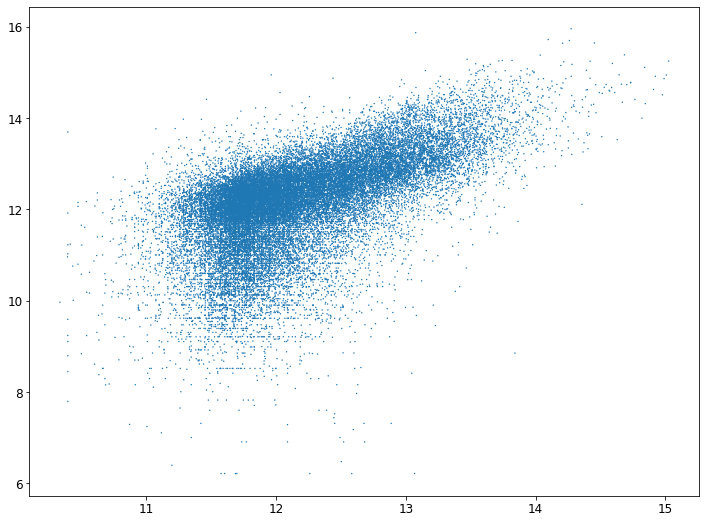

In [32]:
plt.scatter(y_predicted_m2, y_test_m2, s=2, edgecolors='none')

## Part 8 Build Any Model 

From the observation, it is time for us to build any model we want, range from linear regression to neural network. 

How is an example of complex linear regression model 

In [33]:
# Define any additional helper functions you need here
final_model = lm.LinearRegression(fit_intercept=True)

final_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
        'upper': 100000,
    }),
    (remove_outliers, None, {
        'variable': 'Building Square Feet', 
        'lower': 800, 
        'upper': 2400,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Age'})
]

def pipeline(data, pipeline_functions):
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data

# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, is_test_set=False):
    if is_test_set: 
        data['Sale Price'] = 500

    data = pipeline(data, final_pipelines)
    
    expensive_neighborhoods = find_expensive_neighborhoods(data, 3, np.median)
    data = add_in_expensive_neighborhood(data, expensive_neighborhoods) 
    data = select_columns(data, 
                          'Log Sale Price', 
                          'Log Building Square Feet',
                          'Log Land Square Feet',
                          'Log Age',
                          'in_expensive_neighborhood')
    # Return predictors and response variables separately
    X = data.drop(['Log Sale Price'], axis = 1)
    y = data.loc[:, 'Log Sale Price']
    return X, y

training_data = pd.read_csv('cook_county_train.csv')
test_data = pd.read_csv('cook_county_test.csv')

X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data, True)

final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

training_rmse = rmse(delog(y_predicted_train), delog(y_train))
test_rmse = rmse(delog(y_predicted_test), delog(y_test))
training_rmse

543.0991255882863

## The CCAO and Transparency

Additionally, in their approach to fair property valuations, the CCAO has also pushed for transparency initiatives in the property tax assessment system. After a lawsuit was filed against the CCAO for producing [“racially discriminatory assessments and taxes,"](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes) the Office decided that these inequities would be best addressed by making the assessment process more transparent to Cook County constituents.  

These transparency initiatives include publishing all of the CCAO’s work on [GitLab](https://gitlab.com/ccao-data-science---modeling). By allowing the public to access any updates to the system in real-time, the Office argues that they increase accessibility to a process that had previously been blackboxed - obscured and hidden - from the public. Ultimately, the hope is that, by exposing the inner workings of the CCAO’s property valuation process, the CCAO's assessment results could be publicly verified as accurate and therefore trusted to be fair.